In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

### DNA Sequences 113, 52 (worst docked)

First, convert the tpr file to include only protein and DNA topologies


```bash
gmx convert-tpr -s prod_dna_sequence_113_peptide_model_0_worst.tpr -n ../dna_sequence_113_peptide_model_0_worst_water_ion.ndx -o prod_dna_sequence_113_peptide_model_0_worst_compact_compact.tpr
```

Select 'Protein_DNA' and repeat for all trajectories.

In [2]:
import pandas as pd

#Read all the trajectories
dna_113_ku04amp01_model0= mda.Universe('molecular_dynamics/dna_sequence_113_peptide_model_0_worst/sys_prod/prod_dna_sequence_113_peptide_model_0_worst_compact_compact.tpr', 'molecular_dynamics/dna_sequence_113_peptide_model_0_worst/sys_prod/prod_dna_sequence_113_peptide_model_0_worst_compact_compact_compact.xtc')

dna_52_ku04amp01_model0= mda.Universe('molecular_dynamics/dna_sequence_52_peptide_model_0_worst/sys_prod/prod_dna_sequence_52_peptide_model_0_worst_compact_compact.tpr', 'molecular_dynamics/dna_sequence_52_peptide_model_0_worst/sys_prod/prod_dna_sequence_52_peptide_model_0_worst_compact_compact_compact.xtc')


sims = {'113':dna_113_ku04amp01_model0,'52':dna_52_ku04amp01_model0}



## RMSD Calculation

RMSD of DNA

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

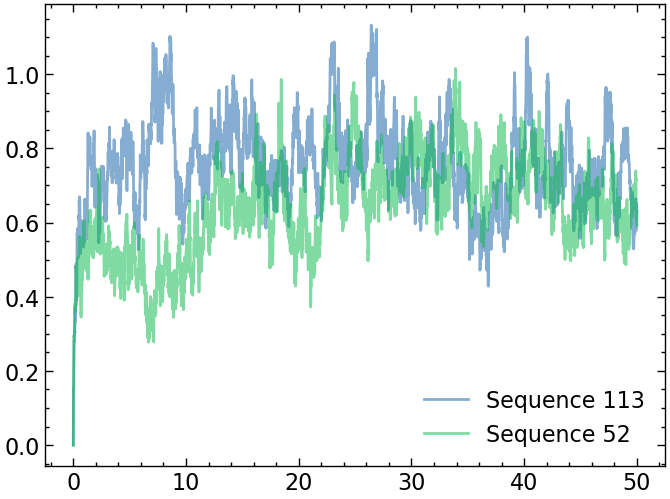

In [23]:
from MDAnalysis.analysis import rms

dfs = {}

for key, value in sims.items():
    R = rms.RMSD(value,  # universe to align
        value,  # reference universe or atomgroup
        select='nucleic',  # group to superimpose and calculate RMSD
        ref_frame=0)  # frame index of the reference

    R.run(verbose=True)
    times = R.results.rmsd[:,1]
    rmsd = R.results.rmsd[:,2]
    plt.plot(times/1000, rmsd/10, alpha=0.5, label=f'Sequence {key}')
    df_rmsd = pd.DataFrame(np.vstack((times, rmsd)).T, columns=["DNA rmsd time", "DNA rmsd"])
    dfs[key] = df_rmsd

plt.legend()


RMSD of Peptide

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

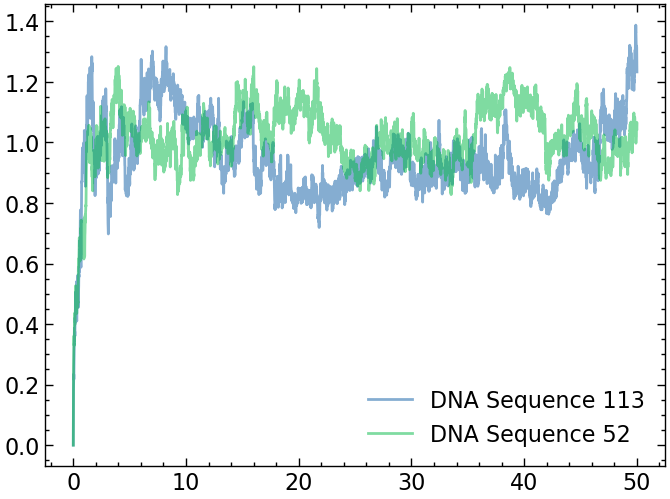

In [24]:
from MDAnalysis.analysis import rms

for key, value in sims.items():
    R = rms.RMSD(value,  # universe to align
        value,  # reference universe or atomgroup
        select='protein',  # group to superimpose and calculate RMSD
        ref_frame=0)  # frame index of the reference

    R.run(verbose=True)
    times = R.results.rmsd[:,1]
    rmsd = R.results.rmsd[:,2]
    plt.plot(times/1000, rmsd/10, alpha=0.5, label=f'DNA Sequence {key}')
    dfs[key] = pd.concat([dfs[key], pd.DataFrame(np.vstack((times, rmsd)).T, columns=["Peptide rmsd time", "Peptide rmsd"])], axis=1)

plt.legend()


## Radius of Gyration Calculation

$R_g$ of the DNA

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

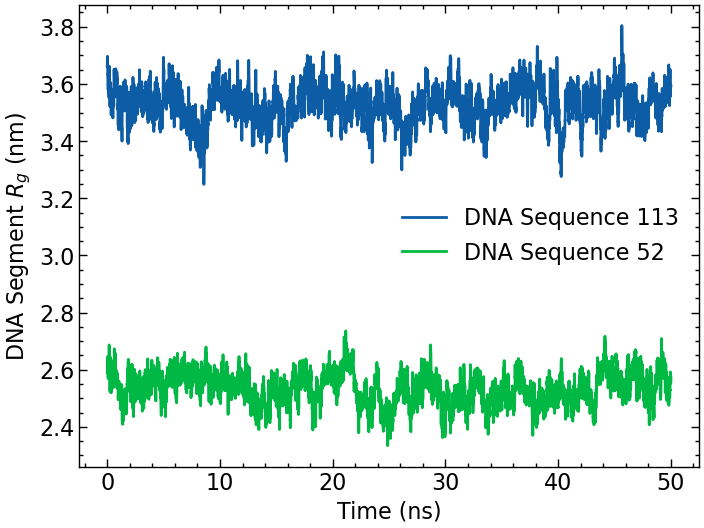

In [25]:
from tqdm.notebook import tqdm


for key, value in sims.items():
    
	group = value.select_atoms('nucleic')		# change the atom selection for your specific system

	Frame = []
	times = []
	Rgyr = []
	for ts in tqdm(value.trajectory):
		Frame.append(ts.frame)
		times.append(value.trajectory.time)
		Rgyr.append(group.radius_of_gyration())

	Rgyrc_table = np.vstack((Frame, times, Rgyr)).T
	dfs[key] = pd.concat([dfs[key], pd.DataFrame(Rgyrc_table, columns=["DNA Rgyr frame", "DNA Rgyr time (ps)", "DNA Rgyr (A)"])], axis=1)
	plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, label=f'DNA Sequence {key}')

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel(r'DNA Segment $R_g$ (nm)')
plt.show()

$R_g$ of peptide

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

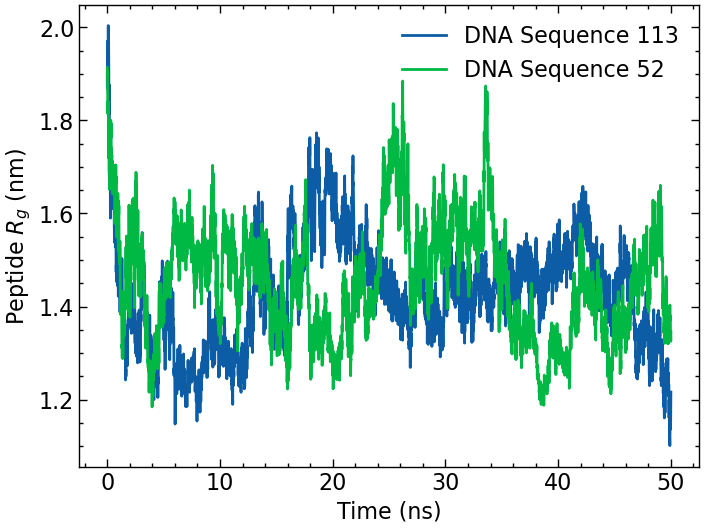

In [26]:
from tqdm.notebook import tqdm


for key, value in sims.items():
    
	group = value.select_atoms('protein')		# change the atom selection for your specific system

	Frame = []
	times = []
	Rgyr = []
	for ts in tqdm(value.trajectory):
		Frame.append(ts.frame)
		times.append(value.trajectory.time)
		Rgyr.append(group.radius_of_gyration())

	Rgyrc_table = np.vstack((Frame, times, Rgyr)).T
	dfs[key] = pd.concat([dfs[key], pd.DataFrame(Rgyrc_table, columns=["Peptide Rgyr frame", "Peptide Rgyr time (ps)", "Peptide Rgyr (A)"])], axis=1)
	plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, label=f'DNA Sequence {key}')

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel(r'Peptide $R_g$ (nm)')
plt.show()

## RMSF Calculation

Between protein backbone and Carbon alphas.

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

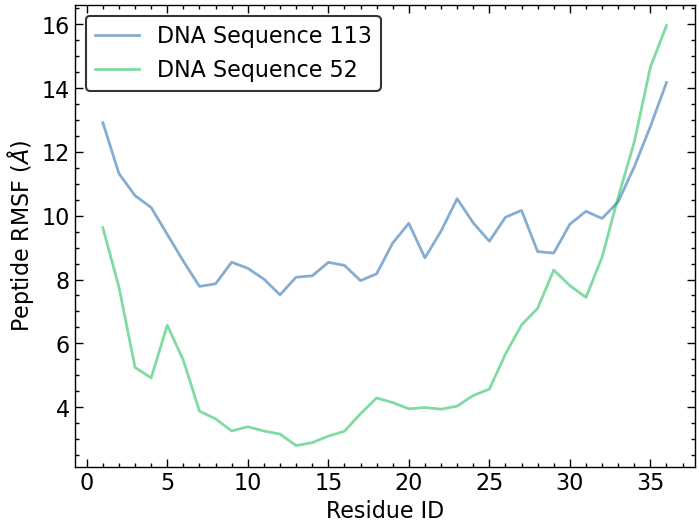

In [27]:
from tqdm.notebook import tqdm

for key, value in sims.items():
    
    c_alphas_c = value.select_atoms('protein and backbone and name CA')
	
    R_c = rms.RMSF(c_alphas_c).run(verbose=True)
    plt.plot(c_alphas_c.resids, R_c.results.rmsf, alpha=0.5, label=f'DNA Sequence {key}')
    dfs[key] = pd.concat([dfs[key], pd.DataFrame(np.vstack((c_alphas_c.resids, R_c.results.rmsf)).T, columns=["Peptide Resids", "RMSF (A)"])], axis=1)

plt.xlabel('Residue ID')
plt.ylabel(r'Peptide RMSF $\left(\AA\right)$')
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.5)

## Hydrogen Bond Analysis

### H-bond parameters
  - *d_h_cutoff* (Å) [1.2] : Distance cutoff used for finding donor-hydrogen pairs
  - *d_a_cutoff* (Å) [3.0] : Distance cutoff for hydrogen bonds. This cutoff refers to the D-A distance.
  - *d_h_a_angle_cutoff* (degrees) [150] : D-H-A angle cutoff for hydrogen bonds.

In [3]:
nucleotides = ["DA", "DG", "DT", "DC"]
amino_acids = [
    "ALA", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU",
    "MET", "ASN", "PRO", "GLN", "ARG", "SER", "THR", "VAL", "TRP", "TYR"
]

Note that we're selecting DNA and protein, so the selections need not be updated with each frame. Setting `update_selections=False` drastically speeds up the hbonds run.

**Note** The selections need to be super precise and atom specific, otherwise there will be many false positives during the hydrogen bond detection, as it will try to 'detect' hydrogen bonds for every atom in the selection, even ones that aren't electronegative enough to be donors and/or acceptors. So selections for donors and acceptors should be obtained with the `guess_` methods.

Note that there are virtually no statistically significant occurrences of hydrogen bonds where DNA is the donor and peptide is the acceptor. I checked and just got :


In [4]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

hbonds_prot_DNA_dict = {}

for key, u in sims.items(): 
    nucleic = u.select_atoms('resname DNA')
    protein = u.select_atoms('protein')
    num_residues = len(protein.residues)
    hbonds_prot_DNA = HBA(universe=u,
        update_selections=False
        )

    hbonds_prot_DNA.donors_sel = hbonds_prot_DNA.guess_donors("protein")
    hbonds_prot_DNA.hydrogens_sel = hbonds_prot_DNA.guess_hydrogens("protein")
    hbonds_prot_DNA.acceptors_sel = hbonds_prot_DNA.guess_acceptors("not protein")

    hbonds_prot_DNA.run(verbose=True)  
    hbonds_prot_DNA_dict[key] = hbonds_prot_DNA 

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

The fraction of total trajectory frames where each type of hydrogen bond is formed (bond probability) is likely more informative than the total number over the trajectory. This can be calculated for each hydrogen bond type as follows:

In [5]:
from tqdm.notebook import tqdm
from collections import Counter
from tabulate import tabulate

all_hbonds = {}

for key, hbonds_prot_DNA in hbonds_prot_DNA_dict.items():

    bonds = []
    u = sims[key]
        
    for hbond in tqdm(hbonds_prot_DNA.results.hbonds):
        frame, donor_ix, hydrogen_ix, acceptor_ix = hbond[:4].astype(int)
        u.trajectory[frame]
        donor_resname = u.atoms[donor_ix].resname
        acceptor_resname = u.atoms[acceptor_ix].resname
        if donor_resname in amino_acids and acceptor_resname in nucleotides:#Exclude DNA donors
            donor_resid = u.atoms[donor_ix].resid
            donor_resname = u.atoms[donor_ix].resname
            donor_atom = u.atoms[donor_ix].name
            hydrogen_atom = u.atoms[hydrogen_ix].name
            acceptor_resid = u.atoms[acceptor_ix].resid
            acceptor_resname = u.atoms[acceptor_ix].resname
            acceptor_atom = u.atoms[acceptor_ix].name
            bonds.append(f'{donor_resid}-{donor_resname} ({donor_atom}:{hydrogen_atom}⋯{acceptor_atom}) {acceptor_resid}-{acceptor_resname}')
        
    bonds_dict = dict(Counter(bonds))
    all_hbonds[key] = bonds_dict



  0%|          | 0/349024 [00:00<?, ?it/s]

  0%|          | 0/250954 [00:00<?, ?it/s]

In [6]:
cutoff = 0.1
hbond_counts_dict = {}
for key, donors_dict in all_hbonds.items():
    print(f"DNA Sequence {key}")
    hbonds_prot_DNA = hbonds_prot_DNA_dict[key]
    table_data = [[donor, count/hbonds_prot_DNA.n_frames] for donor, count in donors_dict.items()]
    table_data.sort(key=lambda x: int(x[0].split('-')[0]))
    hbond_counts_dict[key] = pd.DataFrame(table_data, columns=["Bond Type", "Hydrogen Bond Probability"])
    # Filter out rows with a Hydrogen Bond Probability lower than 0.01
    hbond_counts_dict[key] = hbond_counts_dict[key][hbond_counts_dict[key]["Hydrogen Bond Probability"] >= cutoff]
    table_data = hbond_counts_dict[key].values.tolist()
    print(tabulate(table_data, headers=["Bond Type", "Hydrogen Bond Probability"], tablefmt='markdown'))
    print("-----------------------------------------------")



DNA Sequence 113
Bond Type                      Hydrogen Bond Probability
---------------------------  ---------------------------
2-ASN (ND2:HD21⋯O2P) 59-DA                      0.209158
6-SER (OG:HG⋯O1P) 59-DA                         0.525095
9-ARG (NE:HE⋯O2P) 61-DA                         0.329534
9-ARG (NH2:HH21⋯O2P) 61-DA                      0.135173
16-SER (OG:HG⋯O1P) 82-DT                        0.454309
18-ARG (NH2:HH21⋯O1P) 83-DG                     0.232953
18-ARG (NH1:HH12⋯O1P) 68-DC                     0.194561
18-ARG (NH2:HH22⋯O1P) 68-DC                     0.19756
27-ASN (ND2:HD22⋯O1P) 69-DA                     0.20176
27-ASN (ND2:HD21⋯O1P) 69-DA                     0.111378
31-GLN (NE2:HE21⋯O1P) 69-DA                     0.179964
-----------------------------------------------
DNA Sequence 52
Bond Type                     Hydrogen Bond Probability
--------------------------  ---------------------------
6-SER (OG:HG⋯O2P) 74-DA                        0.226755
9-ARG (NE:HE

In [7]:
# Get the union of all residues across dataframes
all_residues = set()
for df in hbond_counts_dict.values():
    all_residues.update(df["Bond Type"].tolist())

# Define a sorting key that sorts by the numeric part then the residue name
def sort_key(res):
    num, resname = res.split('-', 1)
    return (int(num), resname)

sorted_residues = sorted(all_residues, key=sort_key)

# Reindex each DataFrame so they share the same sorted residues,
# padding missing entries with NaN
for key, df in hbond_counts_dict.items():
    df_indexed = df.set_index("Bond Type")
    df_reindexed = df_indexed.reindex(sorted_residues).reset_index()
    hbond_counts_dict[key] = df_reindexed

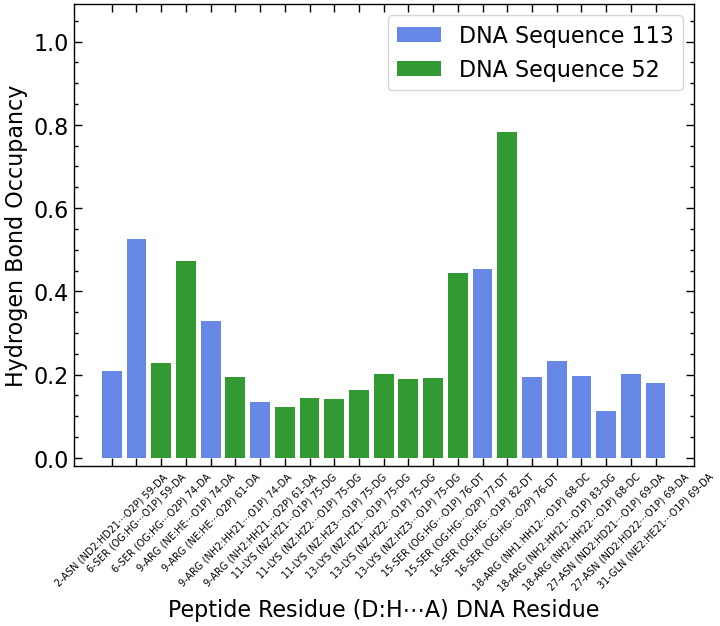

In [8]:
# Extract donors and counts from table_data
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])
fig, ax = plt.subplots()
colors = ['royalblue', 'green', 'orange']
alphas = [0.8, 0.8, 0.8]
for i, (key, df) in enumerate(hbond_counts_dict.items()):
    ax.bar(df["Bond Type"], df["Hydrogen Bond Probability"], alpha=alphas[i], label=f'DNA Sequence {key}', color=colors[i])
    ax.set_xlabel("Peptide Residue (D:H⋯A) DNA Residue")
    ax.set_ylabel("Hydrogen Bond Occupancy")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(-0.02,1.09)
    ax.xaxis.minorticks_off()
    ax.legend(loc="upper right",frameon=True, fancybox=True, shadow=False)
    ax.tick_params(axis='x', labelsize=7)
plt.savefig('dna_sequence_worst_docked_hbond_occupancies.png', dpi=600)
plt.show()

So, the best bonds are:

1. For Seq 113: 6-SER (OG:HG⋯O1P) 59-DA, Occ: 0.525095 AND 16-SER (OG:HG⋯O1P) 82-DT, Occ:0.454309
2. For Seq 52: 16-SER (OG:HG⋯O2P) 76-DT, Occ: 0.783043


So, even in the worst-docked cases, the hydrogen bond occupancy can be as high as around 80%!

### Combined output 

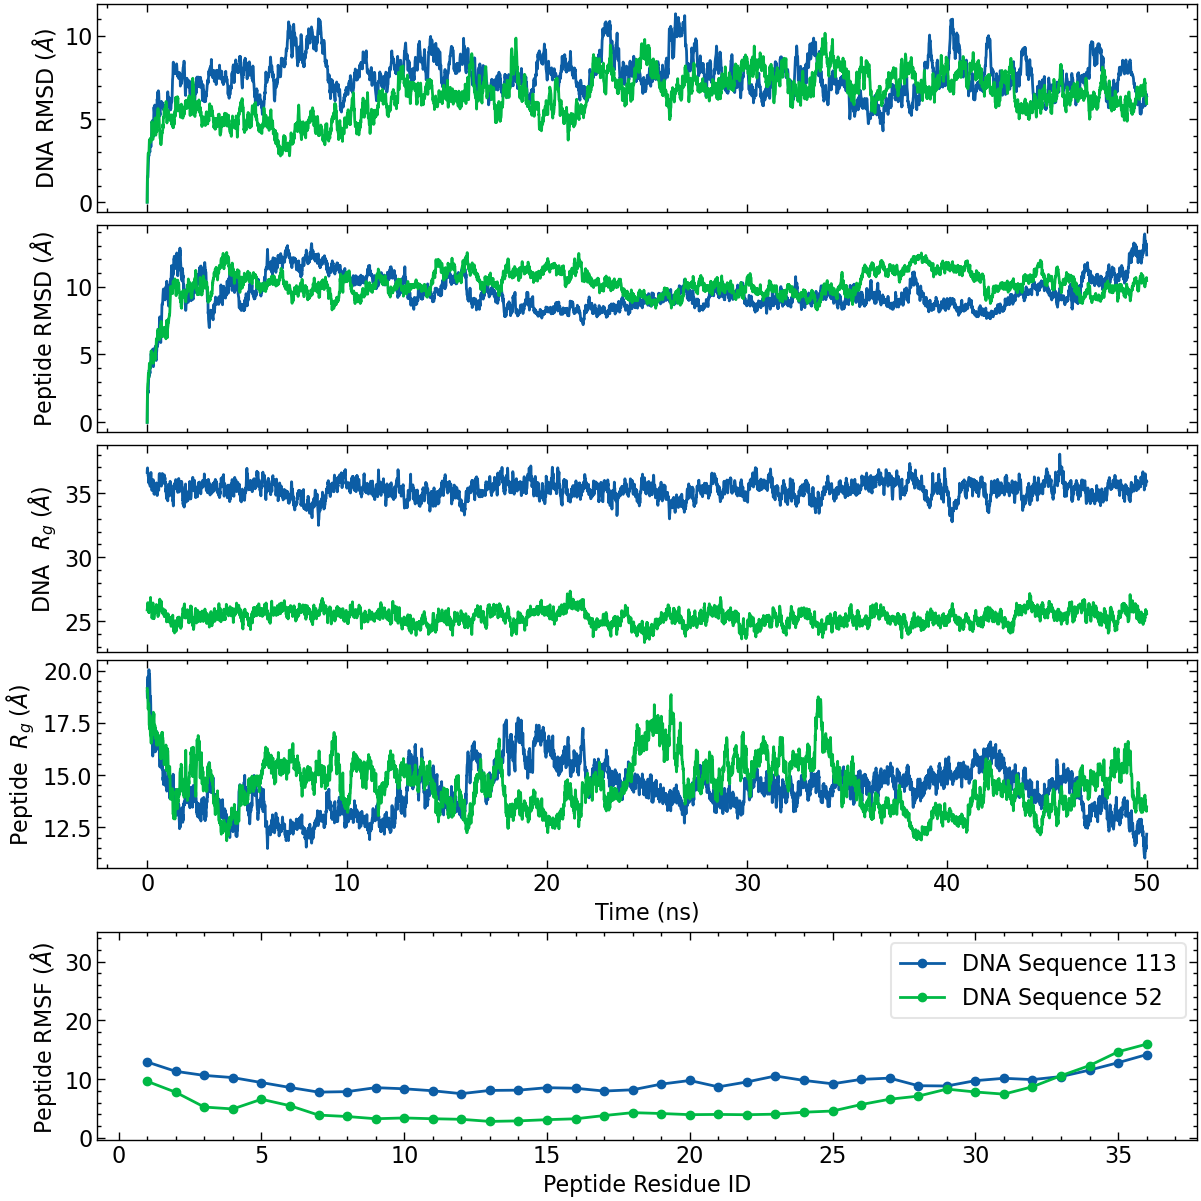

In [44]:
fig, axs = plt.subplots(5, 1, figsize=(12, 12), constrained_layout=True)
for key, df in dfs.items():
    # Panel 1: DNA RMSD vs Time
    axs[0].plot(df["DNA rmsd time"]/1000, df["DNA rmsd"], label=f"DNA Sequence {key}")
    axs[0].set_ylabel(r"DNA RMSD $\left(\AA\right)$")
    axs[0].set_xticklabels([])
    #axs[0].legend()
    
    # Panel 2: Peptide RMSD vs Time
    axs[1].plot(df["Peptide rmsd time"]/1000, df["Peptide rmsd"], label=f"DNA Sequence {key}")
    axs[1].set_ylabel(r"Peptide RMSD $\left(\AA\right)$")
    axs[1].set_xticklabels([])
    #axs[1].legend()

    # Panel 3: Radius of Gyration (DNA) vs Time
    axs[2].plot(df["DNA Rgyr time (ps)"] / 1000, df["DNA Rgyr (A)"], label=f"DNA Sequence {key}")
    axs[2].set_ylabel(r"DNA  $R_g\; \left(\AA\right)$")
    axs[2].set_xticklabels([])
    #axs[1].legend()
    
    # Panel 4: Radius of Gyration (Peptide) vs Time
    axs[3].plot(df["Peptide Rgyr time (ps)"] / 1000, df["Peptide Rgyr (A)"], label=f"DNA Sequence {key}")
    axs[3].set_xlabel("Time (ns)")
    axs[3].set_ylabel(r"Peptide  $R_g\; \left(\AA\right)$")
    #axs[3].legend()

    # Panel 5: RMSF vs Residues
    # Only non-null rows are plotted (RMSF was added for about 36 residues)
    rmsf_data = df[["Peptide Resids", "RMSF (A)"]].dropna()
    axs[4].plot(rmsf_data["Peptide Resids"], rmsf_data["RMSF (A)"], marker='o', linestyle='-', label=f"DNA Sequence {key}")
    axs[4].set_xlabel("Peptide Residue ID")
    axs[4].set_ylabel(r"Peptide RMSF $\left(\AA\right)$ ")
    axs[4].set_ylim(-0.3, 35)
    
    leg = axs[4].legend(loc='upper right', frameon=True, fancybox=True, shadow=False)
    leg.get_frame().set_alpha(0.1)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(1.5)    
plt.savefig('dna_sequence_113_52_peptide_model_0.png', dpi=600)

plt.show()

## Hydrogen Bond lifetimes via correlation analysis

For the h-bond, we plot 

\begin{equation*}
C^{ij}_x(t)=\left\langle\frac{h_{i j}\left(t_0\right) h_{i j}\left(t_0+t\right)}{h_{i j}\left(t_0\right)^2}\right\rangle_{t_0}
\end{equation*}

where 

\begin{equation*}
h_{ij} = \begin{cases}
1 & \text{If hbond: } i \to j\\
0 & \text{otherwise }
\end{cases}
\end{equation*}

The subscript in $C_x$, $x$, can be either $C$ (continuous) or $I$ (intermittent). When $x=C$, a bond, once broken, is assumed to never form again even if conditions are optimal, whereas when $x=I$, bond formation is counted regardless of history. Thus, a low $C_C(t)$ and high $C_I(t)$ indicates the dominance of intermittent hydrogen bonds. The curves are fit to exponential decays to yield bond life times.


In this case, no intermittent bonds were detected, so the bonds are continuous.

Finally, we can estimate the lifetime by fitting to exponential function (see references in MDAnalysis docs)

\begin{equation*}
C_I(t) = A_1 e^{-t/\tau_1} + A_2 e^{-t/\tau_2} 
\end{equation*}

The bond lifetime is given by the numerical integration

\begin{equation*}
\tau_I = \int^\infty_0 C_I(t) \mathrm{d}t.
\end{equation*}

In [167]:
hbl_dict = {}


### First Hydrogen Bond

Seq 113: 6-SER (OG:HG⋯O1P) 59-DA

In [168]:
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

bondname = "Seq 113: 6-SER (OG:HG⋯O1P) 59-DA"

universe = sims['113']

# Perform hydrogen bond analysis
hbonds = HBA(universe,
        donors_sel="protein and resid 6 and resname SER and name OG",
        hydrogens_sel="protein and resid 6 and resname SER and name HG",
        acceptors_sel="nucleic and resid 59 and resname DA and name O1P",
        update_selections=False
    ).run(verbose=True)


  0%|          | 0/5001 [00:00<?, ?it/s]

In [169]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

tau_max = 60
stride = 3


# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2)


def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
    )
    return np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
hbl = calculate_lifetime(hbonds)
taus, hbl = hbl[:, 0], hbl[:, 1]
times = taus * universe.trajectory.dt/1000


popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[1, 0.01, 1, 1], maxfev=15000)
fit_times = np.linspace(times[0], times[-1], 100)
fit_hbl = hbond_corr(fit_times, *popt)
tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 


new_row = {
    'Bond Name': [bondname],
    'Times': [times],
    'hbl': [hbl],
    'Fit Times': [fit_times],
    'Fit hbl': [fit_hbl],
    'Tau_i_ps': [tau_i_ps]
}

hbl_dict[bondname] = new_row


### Second Hydrogen Bond

Seq 113: 16-SER (OG:HG⋯O1P) 82-DT


In [170]:
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
bondname = "Seq 113: 16-SER (OG:HG⋯O1P) 82-DT"

universe = sims['113']

# Perform hydrogen bond analysis
hbonds = HBA(universe,
        donors_sel="protein and resid 16 and resname SER and name OG",
        hydrogens_sel="protein and resid 16 and resname SER and name HG",
        acceptors_sel="nucleic and resid 82 and resname DT and name O1P",
        update_selections=False
    ).run(verbose=True)


  0%|          | 0/5001 [00:00<?, ?it/s]

In [171]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

tau_max = 60
stride = 3


# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2)


def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
    )
    return np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
hbl = calculate_lifetime(hbonds)
taus, hbl = hbl[:, 0], hbl[:, 1]
times = taus * universe.trajectory.dt/1000


popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[1, 0.01, 1, 1], maxfev=15000)
fit_times = np.linspace(times[0], times[-1], 100)
fit_hbl = hbond_corr(fit_times, *popt)
tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 


new_row = {
    'Bond Name': [bondname],
    'Times': [times],
    'hbl': [hbl],
    'Fit Times': [fit_times],
    'Fit hbl': [fit_hbl],
    'Tau_i_ps': [tau_i_ps]
}

hbl_dict[bondname] = new_row


### Third Hydrogen Bond
Seq 52: 16-SER (OG:HG⋯O2P) 76-DT


In [172]:
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
bondname = "Seq 52: 16-SER (OG:HG⋯O2P) 76-DT"

universe = sims['52']

# Perform hydrogen bond analysis
hbonds = HBA(universe,
        donors_sel="protein and resid 16 and resname SER and name OG",
        hydrogens_sel="protein and resid 16 and resname SER and name HG",
        acceptors_sel="nucleic and resid 76 and resname DT and name O2P",
        update_selections=False
    ).run(verbose=True)


  0%|          | 0/5001 [00:00<?, ?it/s]

In [173]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

tau_max = 60
stride = 3


# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2)


def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
    )
    return np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
hbl = calculate_lifetime(hbonds)
taus, hbl = hbl[:, 0], hbl[:, 1]
times = taus * universe.trajectory.dt/1000


popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[1, 0.01, 1, 1], maxfev=15000)
fit_times = np.linspace(times[0], times[-1], 100)
fit_hbl = hbond_corr(fit_times, *popt)
tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 


new_row = {
    'Bond Name': [bondname],
    'Times': [times],
    'hbl': [hbl],
    'Fit Times': [fit_times],
    'Fit hbl': [fit_hbl],
    'Tau_i_ps': [tau_i_ps]
}

hbl_dict[bondname] = new_row

### Plot all Hydrogen Bond Lifetimes 

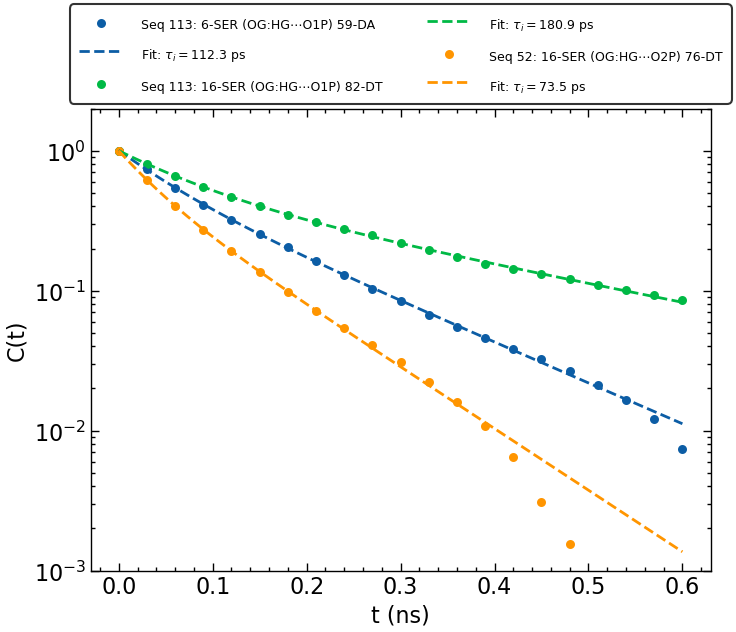

In [183]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])


for key, value in hbl_dict.items():
    plt.scatter(value['Times'][0][::stride], value['hbl'][0][::stride], label= key, lw=2, s=20)
    plt.plot(value['Fit Times'][0], value['Fit hbl'][0], ls='--', lw=2, label=f'Fit: $\\tau_i = {value["Tau_i_ps"][0]}$ ps')

plt.xlabel('t (ns)')
plt.ylabel('C(t)')
plt.yscale('log')
plt.ylim(1e-3, 2)
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncols=2, frameon=True, fancybox=True, shadow=False)
#leg = plt.legend(loc='lower left',
#                ncols=2, frameon=True, fancybox=True, shadow=False)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.5)
plt.setp(leg.get_texts(), fontsize=9)
plt.savefig("hbond_lifetimes_worst_docked.png", dpi=600)
plt.show()